# Carbon cycle project

As described in the model equations pages We can write the evolution of the variables with time as a Cauchy problem :

\begin{cases}
y'(t) = f(t, y(t)) & \forall t \in [t0, T+t0]\\
y(0) = y_0
\end{cases}

with $f :\mathbb{R} \times \mathbb{R}^8 \to \mathbb{R}^8$  

We take $T=750 $ years and $ t0=1800$ years as mentionned in the in the website Model equations

such that our vector $y$ is described by : 
$y(t) = \begin{bmatrix}
y_1(t) \\
y_2(t) \\
y_3(t) \\
y_4(t) \\
y_5(t) \\
y_6(t) \\
y_7(t) \\
y_8(t)
\end{bmatrix} = \begin{bmatrix}
Atmoshpere(t) \\
CarbonateRock(t) \\
DeepOcean(t) \\
FossilFuelCarbone(t) \\
Plants(t) \\
Soils(t) \\
SurfaceOcean(t) \\
VegLandArea(t) \\
\end{bmatrix} \in \mathbb{R}^8$


Besides, in the notebook " carbone.py " we have already the initial conditions for the vector $y$ :

$$y(0) = \begin{bmatrix}
y_1(0) \\
y_2(0) \\
y_3(0) \\
y_4(0) \\
y_5(0) \\
y_6(0) \\
y_7(0) \\
y_8(0)
\end{bmatrix} =  \begin{bmatrix}
750 \\
100000000 \\
38000 \\
7500 \\
560 \\
1500 \\
890 \\
100 \\
\end{bmatrix}$$




In [1]:
# All imports of libraries go here
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#The code necessary for the value of the derivative of y in the diffferential equation.


# Initial conditions
Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)


# Fossil fuels
FossFuelData = np.array([[1850.0, 0.00], [1875.0, 0.30], [1900.0, 0.60], [1925.0, 1.35], [1950.0, 2.85], [1975.0, 4.95], [2000.0, 7.20], [2025.0, 10.05], [2050.0, 14.85], [2075.0, 20.70], [2100.0, 30.00]])
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative




# One-step methods:

## Euler's method
The method we will implement is the explicit Euler method. It is used to find an approximate solution for initial value problems of ordinary differential equations (ODEs). The sequence of values we obtain is given by the following formula:

$$ y_{n+1} = y_n + h_n f(y_n, t_n) $$

This formula is applied for $n$ varying from $0$ to $N-1$, where $t_N = t_0 + T$. Here, $y_n$ represents the approximate value of the solution at time $t_n$, $h_n$ is the step size, and $f(y_n, t_n)$ is the derivative of the solution at time $t_n$.

<h1>The code<h1>

In [3]:
def Euler(x0, t0, tN, f, N):

    t = np.linspace(t0, tN, N + 1)

    # Defining the steps h
    h = t[1]-t[0]

    # Computing the values of y and storing them
    d = len(x0)
    y = np.zeros((N + 1, d))
    y[0] = x0
    for i in range(N):
        y[i + 1] = y[i] + h * f(y[i], t[i])
    return y


<h1>Visualisation of the code<h1>

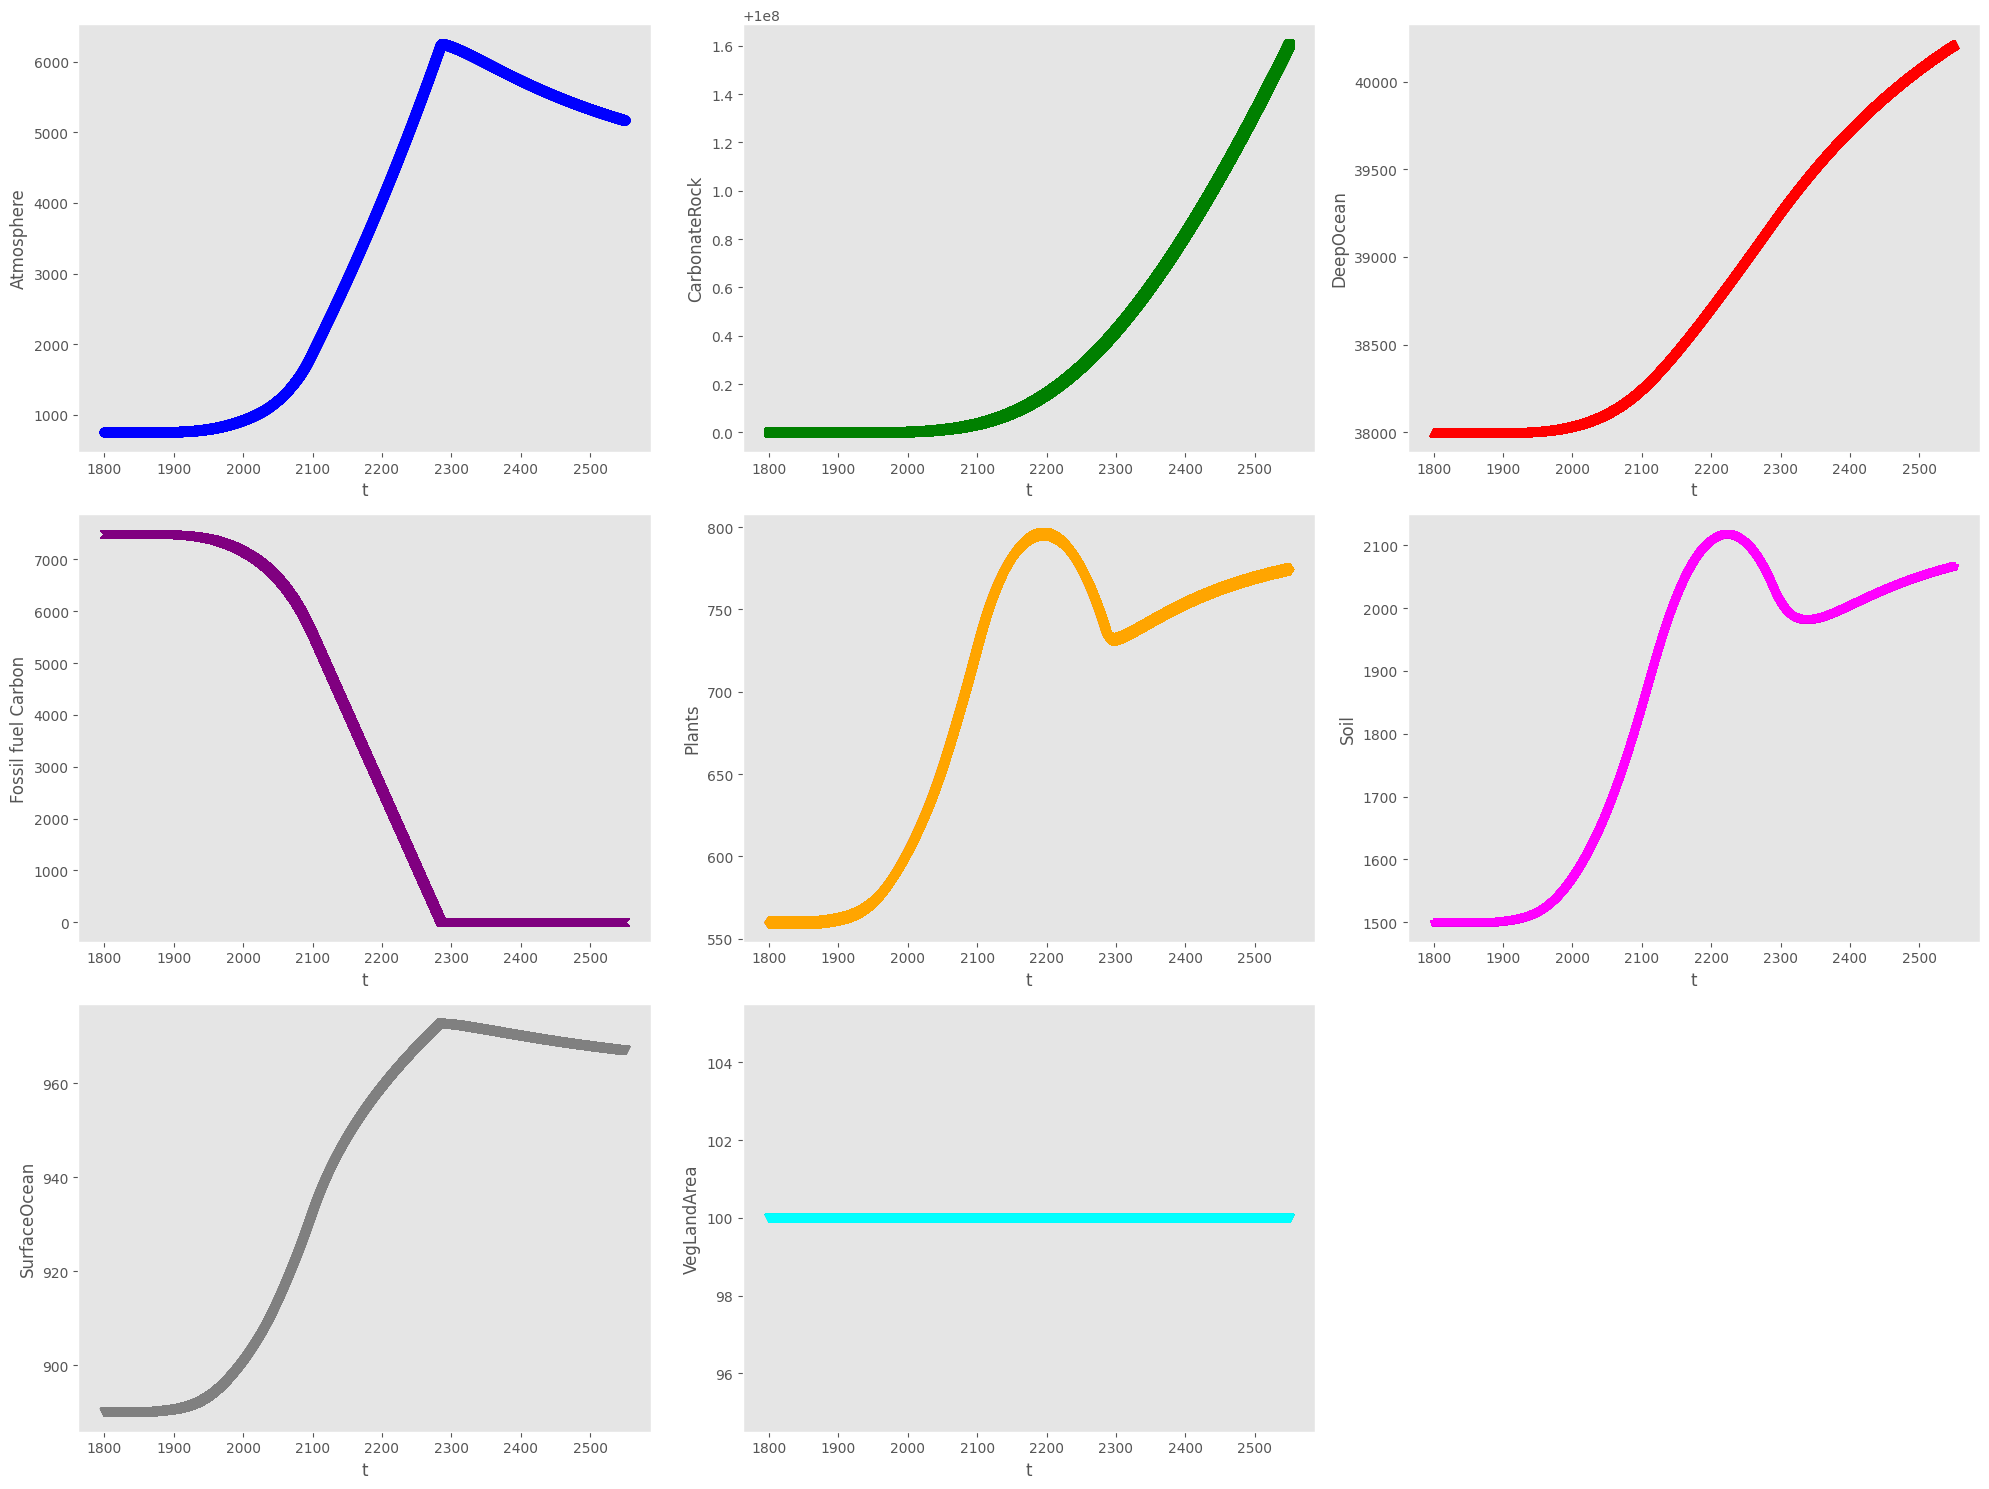

In [4]:
# Parameters
t0 = 1800
tN = 750 + t0
N = 100000

# Computation
t = np.linspace(t0, tN, N + 1)
y = Euler(x0, t0, tN, derivative, N)  # Assuming Euler function is defined elsewhere

# Plotting
plt.figure(figsize = (20, 15))  # Adjust figure size for better visualization


# Atmosphere plot
plt.subplot(3, 3, 1)
plt.plot(t, y[:, 0], marker='o', color='blue')
plt.xlabel("t")
plt.ylabel("Atmosphere")
plt.grid()

# CarbonateRock plot
plt.subplot(3, 3, 2)
plt.plot(t, y[:, 1], marker='s', color='green')
plt.xlabel("t")
plt.ylabel("CarbonateRock")
plt.grid()

# DeepOcean plot
plt.subplot(3, 3, 3)
plt.plot(t, y[:, 2], marker='^', color='red')
plt.xlabel("t")
plt.ylabel("DeepOcean")
plt.grid()

# Fossil fuel Carbon plot
plt.subplot(3, 3, 4)
plt.plot(t, y[:, 3], marker='x', color='purple')
plt.xlabel("t")
plt.ylabel("Fossil fuel Carbon")
plt.grid()

# Plants plot
plt.subplot(3, 3, 5)
plt.plot(t, y[:, 4], marker='d', color='orange')
plt.xlabel("t")
plt.ylabel("Plants")
plt.grid()

# Soil plot
plt.subplot(3, 3, 6)
plt.plot(t, y[:, 5], marker='*', color='magenta')
plt.xlabel("t")
plt.ylabel("Soil")
plt.grid()
 
# SurfaceOcean plot
plt.subplot(3, 3, 7)
plt.plot(t, y[:, 6], marker='v', color='grey')
plt.xlabel("t")
plt.ylabel("SurfaceOcean")
plt.grid()

# VegLandArea plot
plt.subplot(3, 3, 8)
plt.plot(t, y[:, 7], marker='v', color='cyan')
plt.xlabel("t")
plt.ylabel("VegLandArea")
plt.grid()

plt.tight_layout()  
plt.show()





## Runge Kutta methods with q = 2

Here we are going to implement the order 2 $\textbf{Runge Kutta}$ methods with q = 2 : 

To garantie that the order is 2 , we choose the coeffecients $ \alpha $ and $\beta $ such that : $ \alpha$ $\beta$ =$ \frac{1}{2} $   

In fact in $ \textbf{Euler method}$ the order was 1 , so here we try to augment the order and reduce the step so that the method converges to an exact solution.

 - For $\textbf{Runge Kutta methods with q = 2}$, we have :

$$  \begin{array}{c|cc} 0 & 0 & 0 \\ \alpha & \alpha & 0 \\ \hline & 1-\frac{1}{2\alpha} & \frac{1}{2\alpha} \end{array} $$

So it all depends on the coefficient $\alpha $

In [5]:
def rk_order2(z0 , f , t0,tN, N,alpha):
    '''
    This function implements Runge-Kutta 2nd order methods

    z0: initial value
    f: function
    t0: initial time
    tN: final time
    N: number of steps
    alpha: butcher tableau coefficient

    Returns: array of values of z
    '''
    # Defining the steps
    t = np.linspace(t0, tN, N + 1)
    z = np.zeros((len(t), 8))
    z[0] = z0
    
    for i in range(len(t)-1):

        # Defining the steps
        dt = t[i+1] - t[i]
        
        p1 = f(z[i] , t[i])
        p2 = f(z[i] + dt*alpha*p1 , t[i] + dt*alpha )
        
        z[i+1] = z[i] + dt*(p1*(1-1/(2*alpha)) + p2*(1/(2*alpha)))
        
    return z

 Now we will visualise three prominent runge kutta methods of order 2, the midpoint method, heun methode, and the Ralston method.


for $\alpha =1 $, we get $\textbf{the Midpoint method}$

for $ \alpha = 1/2$ ,  we get $\textbf{the heun method}$

for $\alpha = 2/3$ , we get $\textbf{Ralston's method}$

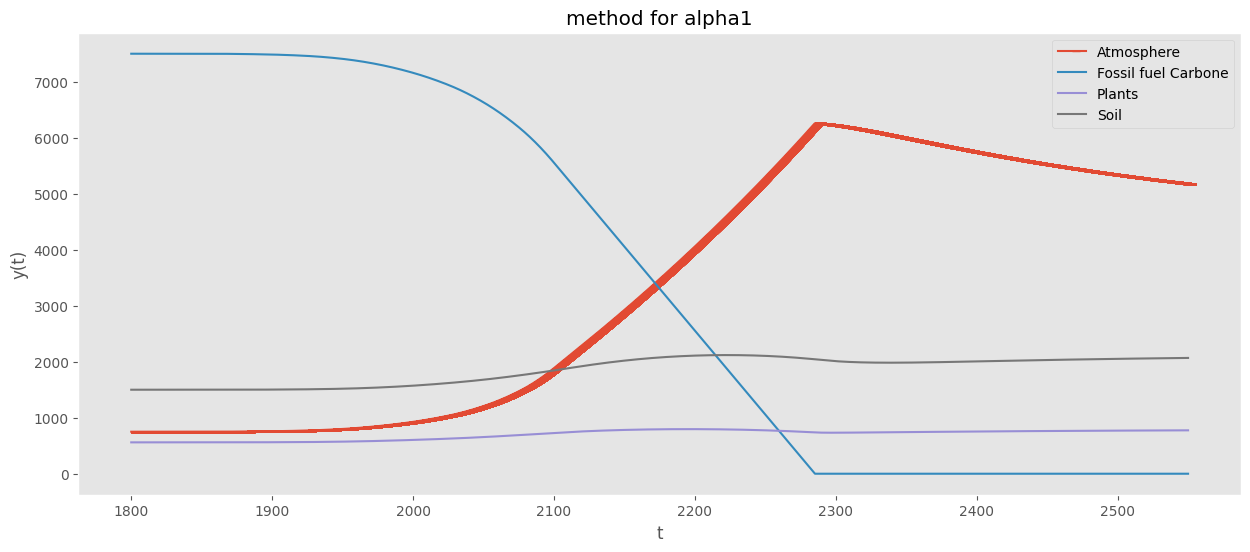

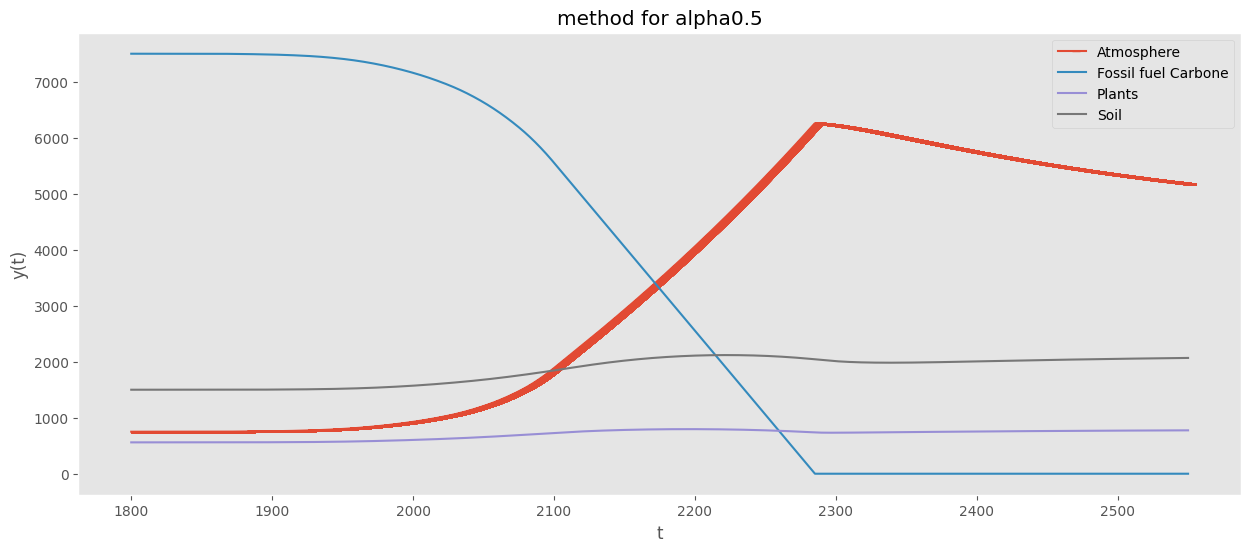

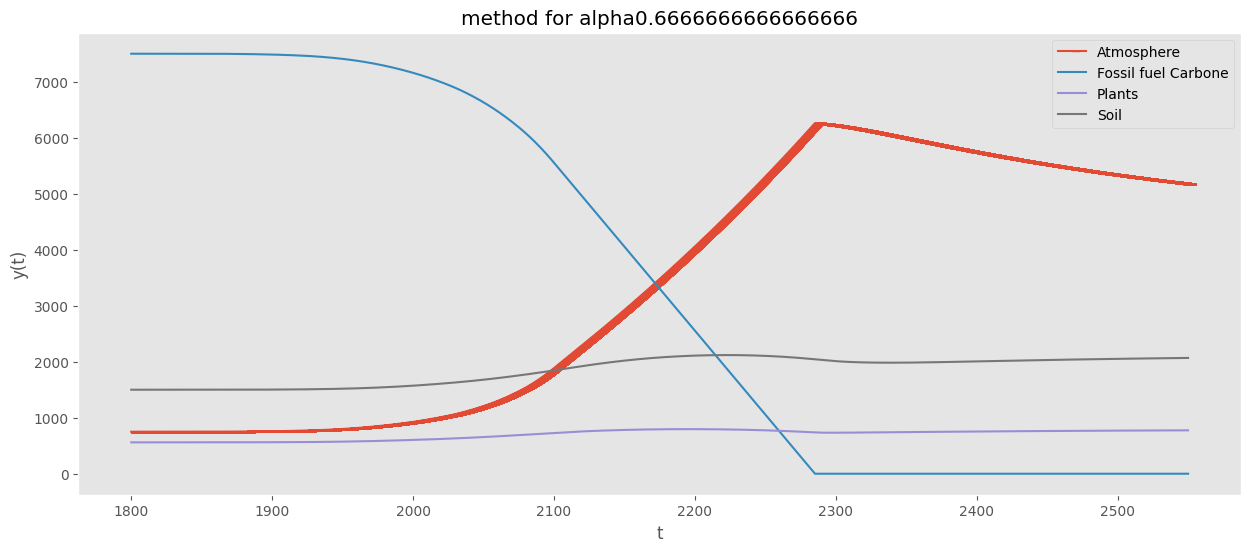

In [6]:
#visualisation
# Parameters
t0 = 1800
tN = 750 + t0
N = 100000
# Computation
l=[1, 0.5 , 2/3]
t = np.linspace(t0, tN, N + 1)
def draw(alpha):
    f=rk_order2(x0 , derivative , t0,tN, N,alpha)
    plt.figure(figsize = (15, 6))
    plt.plot(t, f[:, 0], marker = 1, label = "Atmosphere")
    plt.plot(t, f[:, 3], label = "Fossil fuel Carbone")
    plt.plot(t, f[:, 4], label = "Plants")
    plt.plot(t, f[:, 5], label = "Soil")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("method for alpha" + str(alpha))
    plt.legend()
    plt.grid()
    plt.show()
    
for i in range(3) :
    
   draw(l[i])

(the plant and soil graphs are also accurate , but the difference in scale between them and the other attributes makes them seem flat)

## Runge-Kutta method with $q = 4$

Below we have implemented the Runge-Kutta method with $q = 4$. 

Its $\textbf{Butcher tableau} $ is the following, where the coefficients have been chosen using $\textbf{the Simpson method}$ :
$$ 
\begin{array}{c|cccc} 
0 & 0 & 0 & 0 & 0 \\ 
1/2 & 1/2 & 0 & 0 & 0 \\ 
1/2 & 0 & 1/2 & 0 & 0 \\ 
1 & 0 & 0 & 1 & 0 \\ 
\hline 
& 1/6 & 1/3 & 1/3 & 1/6 
\end{array} 
$$



In [7]:
def rk4(z0 , f, t0,tN, N):
    '''
    This function implements Runge-Kutta 4th order method

    z0: initial value
    f: function
    t0: initial time
    tN: final time
    N: number of steps

    Returns: array of values of z
    '''
    # Defining the steps
    t = np.linspace(t0, tN, N + 1)
    z = np.zeros((len(t), 8))
    z[0] = z0

    for i in range(len(t)-1):

        # Defining the steps
        dt = t[i+1] - t[i]

        p1 = f(z[i] , t[i])
        p2 = f(z[i] + dt*p1/2 , t[i] + dt/2 )
        p3 = f( z[i] + dt*p2/2 , t[i] + dt/2 )
        p4 = f( z[i] + dt*p3 , t[i] + dt )


        z[i+1] = z[i] + dt*(p1 + 2*p2 + 2*p3 + p4)/6

    return z

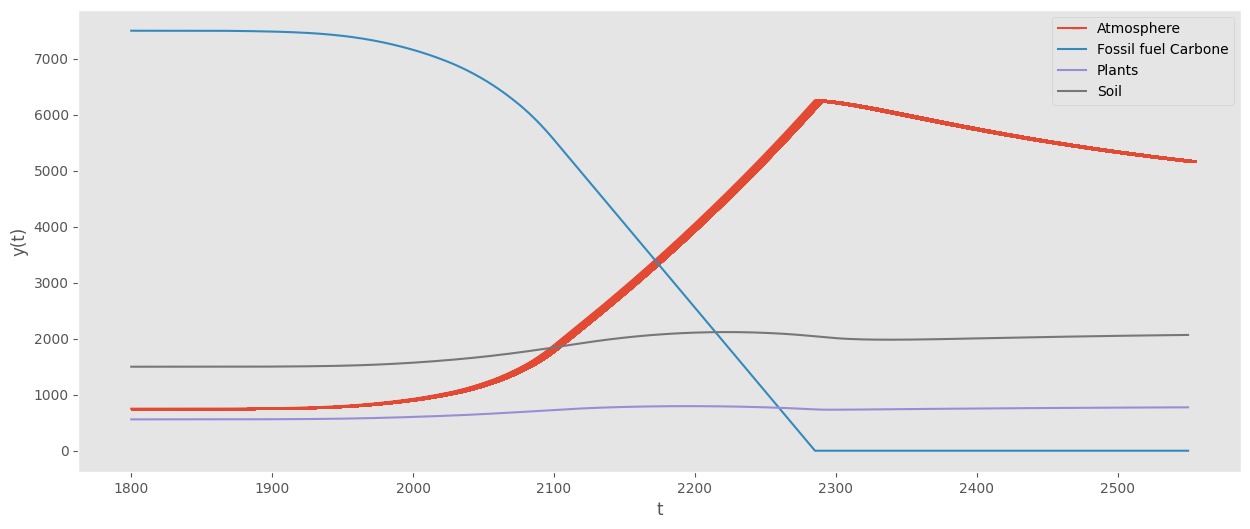

In [8]:
y = rk4(x0, derivative,  t0, tN, N)

# Plotting
plt.figure(figsize = (15, 6))
plt.plot(t, y[:, 0], marker = 1, label = "Atmosphere")
plt.plot(t, y[:, 3], label = "Fossil fuel Carbone")
plt.plot(t, y[:, 4], label = "Plants")
plt.plot(t, y[:, 5], label = "Soil")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.grid()
plt.show()

## General Implementation of the Runge-Kutta Method:

This implementation takes the Butcher table $(c, a, b)$ of the method as input and returns the sequence of approximations to the solution of the Cauchy problem. The coefficients are chosen such that the Runge-Kutta method attains an order of 7.


The Butcher table is a compact representation of the coefficients required for the Runge-Kutta method, including the coefficients $c$ for evaluation points, coefficients $a$ for step weights, and coefficients $b$ for the linear combination of contributions from each step.

By inputting the Butcher table into this implementation, one obtains a sequence of approximations to the solution of the Cauchy problem. The Cauchy problem is a fundamental problem in analysis where one seeks to find a solution to an ordinary differential equation with a given initial condition.

Thus, this implementation of the Runge-Kutta method provides an essential tool for efficiently solving Cauchy problems through numerical approximations.


In [9]:
# General Runge-Kutta
def Runge_Kutta(y0, t0, tN, f, N, c, a, b):
    '''
    This function implements Runge-Kutta method for any order
    y0: initial value
    t0: initial time
    tN: final time
    f: function
    N: number of steps
    a,b,c: coeficients of the Butcher Tableau
    returns: y
    '''


    q = len(b)
    d = len(y0)

    # defining the matrix Y and y and p and t
    y = np.zeros((N + 1, d))
    p = np.zeros((q, d))
    t = np.linspace(t0, tN, N + 1)
    T = np.zeros(q)
    h = t[1:] - t[:-1]

    # initilizing
    y[0] = y0


    # computing the values
    for n in range(N):
        for i in range(1,q):
            p[i] = f( y[n] + h[n] * (a[i] @ p), t[n] + c[i - 1] * h[n])
        y[n + 1] = y[n] + h[n] * (b @ p)
    return y



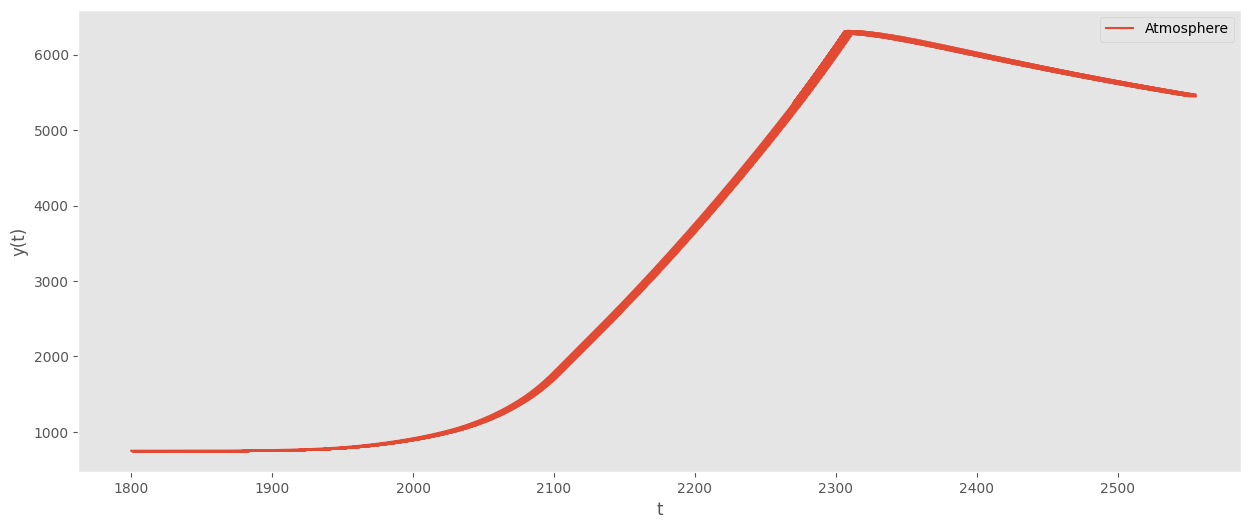

In [10]:
# Testing the function

t0 = 1800
tN = 750 + t0
N = 10000
# Coefficients for a seventh-order Runge-Kutta method(obtained online)
c = np.array([0, 1/5, 3/10, 4/5, 8/9, 1, 1])
b = np.array([7/90, 0, 32/90, 12/90, 32/90, 7/90, 0])
a = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [1/5, 0, 0, 0, 0, 0, 0],
    [3/40, 9/40, 0, 0, 0, 0, 0],
    [44/45, -56/15, 32/9, 0, 0, 0, 0],
    [19372/6561, -25360/2187, 64448/6561, -212/729, 0, 0, 0],
    [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656, 0, 0],
    [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]
])
y = Runge_Kutta(x0, t0, tN, derivative, N, c, a, b)
t = np.linspace(t0, tN, N + 1)
# Plotting
plt.figure(figsize = (15, 6))
plt.plot(t, y[:, 0], marker = 1, label = "Atmosphere")

plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.grid()
plt.show()

## Performance comparison:
To compare the performance of our different numerical methods,, we will compare their error relative to the exact solution, but since we do not have access to an exact solution, we will consider the result given by the RK4 method with a very small step size (or equivalently a very large N).


In [11]:
#This will be considered our exact solution.

N= 500000
y = rk4(x0, derivative, t0, tN, N)
print(y.shape)

(500001, 8)


Now, since our exact solution is a matrix of size $ (500001, 8) $, and our results using methods other than RK4 will have a much smaller dimension, calculating the error wont be so simple as we would need to know what values to compare against each other:

For example, in our case, if we wanted to compare the results of a euler method with $ N_1=10000 $ against a RK4 method with $N_2=500000 $, we would need to compare every i-nth 

value of the euler list against the 50*i-nth  ($\frac{N_2}{N_1} $) value of the RK4 list for our error analysis to make sense.(comparing values corresponding to the same t)

Thus, to compute the error, it's necessary to juxtapose the outcomes from our methods against the exact solution.

However, given that our exact solution emanates from a $\textbf{Runge-Kutta method with order 4}$ employing a notably large step (We opted for $ N=500000 $), we must compareour $\textbf{"smallMatrice"}$ against specific selections from our $\textbf{"bigMatrice"}$. This ensures a comparison of values that correspond to the same abscissa on the graph (same $t$).


So, the following function will allow us to make this comparison between matrices of different sizes, here we are considering the $L^2$  error.

This error will need to be normalised, as it could potentially lead to results  favoring implementations with a smaller N , even if they could yield bigger errors (as the total error is proportionnal to N).

In [12]:
def Matrices_comparison(smallMatrice, bigMatrice):

    error = 0
    sizeRatio = bigMatrice.shape[0] // smallMatrice.shape[0]
    for i in range(smallMatrice.shape[0]):
        for j in range(smallMatrice.shape[1]):
            error += ((bigMatrice[i*sizeRatio, j] - smallMatrice[i, j])/bigMatrice[i*sizeRatio,j]) ** 2
    # compute the square of the difference between the two matrices
    return error/(smallMatrice.shape[0] * smallMatrice.shape[1])

We are also going to need to a similar function but for vectors.

In [13]:
def Vectors_comparison(smallvector, bigvector):
 
    error = 0
    sizeRatio = bigvector.shape[0] // smallvector.shape[0]
    for i in range(smallvector.shape[0]):
            error += ((bigvector[i*sizeRatio] - smallvector[i]) ** 2)
    # compute the square of the difference between the two matrices
    return error/(smallvector.shape[0])

Now we will plot the error corresponding to N, for the Ralston, Heun, Euler and Midpoint methods.(there is no point in testing the RK4 method since it was used as our benchmark for an exact solution)

C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:40: RuntimeWarning: overflow encountered in scalar multiply
  return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:36: RuntimeWarning: invalid value encountered in scalar divide
  return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: overflow encountered in scalar power
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: invalid value encountered in scalar divide
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb)

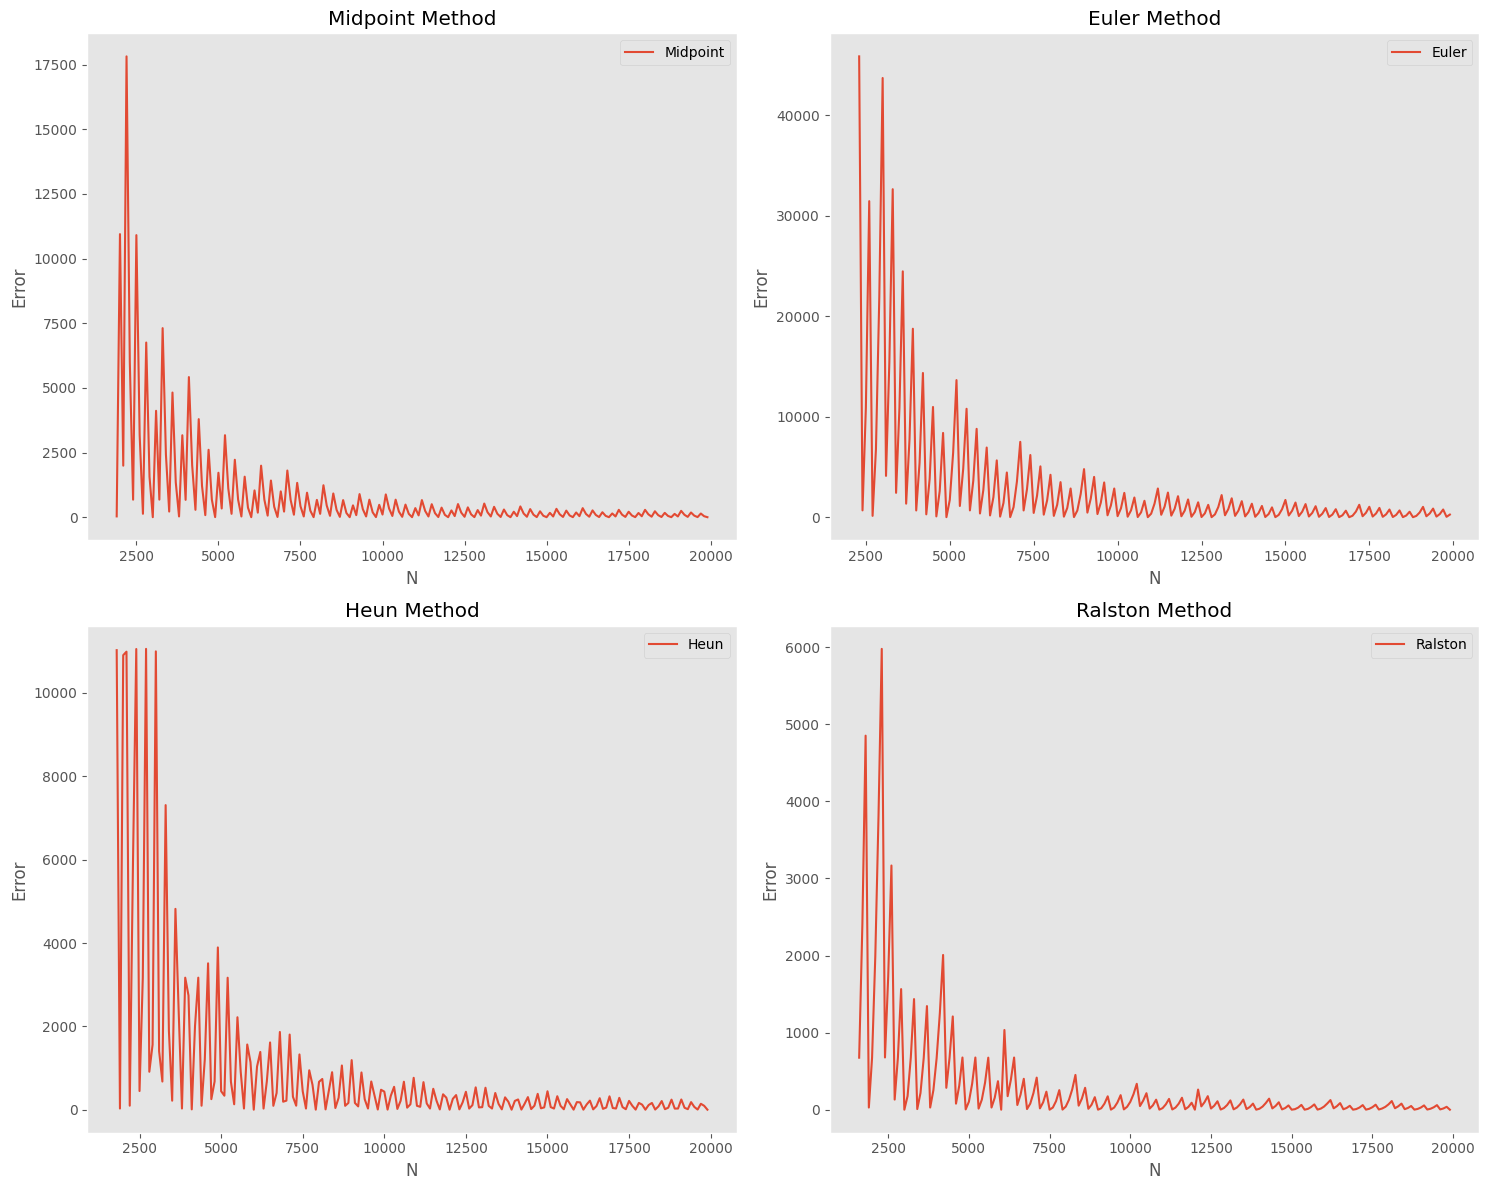

In [14]:

N_values = np.arange(100, 20000, 100)

#These will contain the errors correspondiing to certain N values
error_midpoint = np.zeros(len(N_values))
error_Euler = np.zeros(len(N_values))
error_Heun = np.zeros(len(N_values))
error_Ralston = np.zeros(len(N_values))

for i in range(len(N_values)):
    Ralston = rk_order2(x0, derivative, t0, tN, N_values[i],2/3)
    euler = Euler(x0, t0, tN, derivative, N_values[i])
    Heun = rk_order2(x0, derivative, t0, tN, N_values[i],1/2)
    Midpoint = rk_order2(x0, derivative, t0, tN, N_values[i],1)

    # compute the error between the whole matrices yi and y
    error_midpoint[i] = Matrices_comparison(Midpoint, y)
    error_Euler[i] = Matrices_comparison(euler, y)
    error_Heun[i] = Matrices_comparison(Heun, y)
    error_Ralston[i] = Matrices_comparison(Ralston, y)


# Plotting the error for each method separately
plt.figure(figsize=(15, 12))

# Midpoint method
plt.subplot(2, 2, 1)
plt.plot(N_values, error_midpoint, label="Midpoint")
plt.xlabel("N")
plt.ylabel("Error")
plt.title("Midpoint Method")
plt.legend()
plt.grid()

# Euler method
plt.subplot(2, 2, 2)
plt.plot(N_values, error_Euler, label="Euler")
plt.xlabel("N")
plt.ylabel("Error")
plt.title("Euler Method")
plt.legend()
plt.grid()

# Heun method
plt.subplot(2, 2, 3)
plt.plot(N_values, error_Heun, label="Heun")
plt.xlabel("N")
plt.ylabel("Error")
plt.title("Heun Method")
plt.legend()
plt.grid()

# Ralston method
plt.subplot(2, 2, 4)
plt.plot(N_values, error_Ralston, label="Ralston")
plt.xlabel("N")
plt.ylabel("Error")
plt.title("Ralston Method")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


We can see that for all methods, the error converges towards 0 as N grows (so as the step size decreases),and we can also see that error converges towards 0 faster for the RK2 methods as they are of order 2, and euler is of order 1






Lets visualise the error for each parameter using the previous four methods

C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:40: RuntimeWarning: overflow encountered in scalar multiply
  return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:36: RuntimeWarning: invalid value encountered in scalar divide
  return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: overflow encountered in scalar power
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: invalid value encountered in scalar divide
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb)

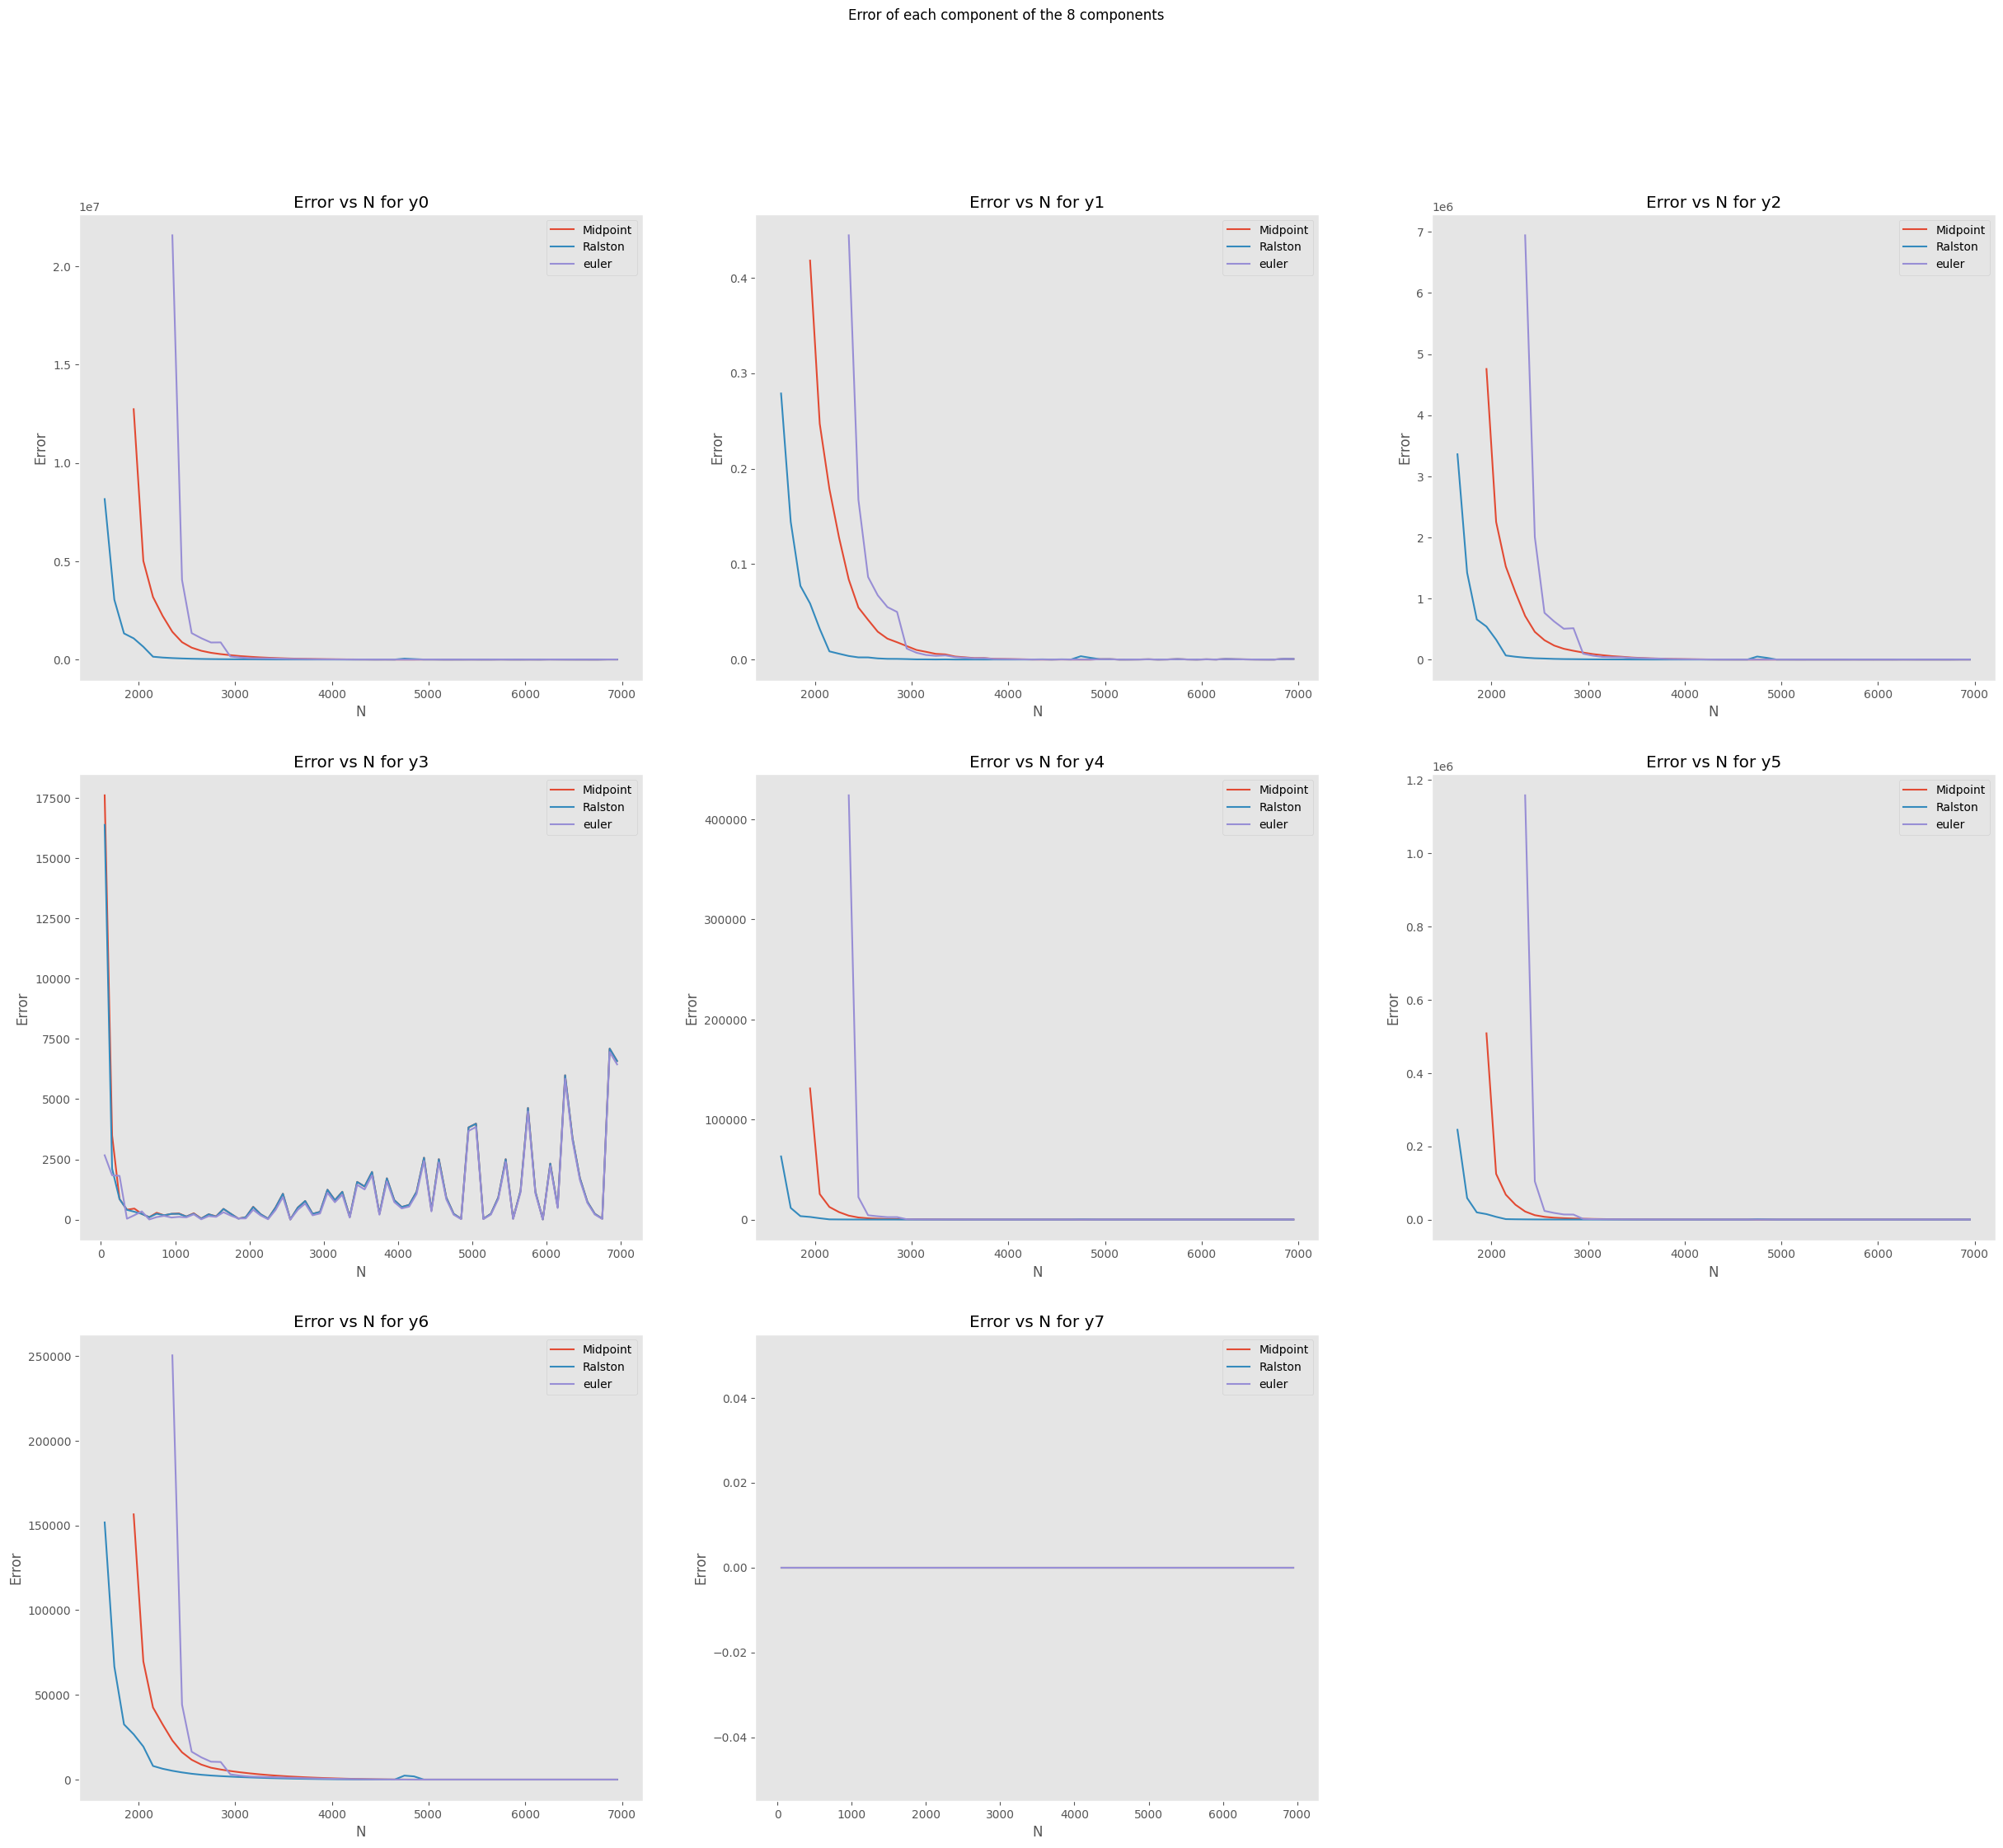

In [15]:
# this is the error of each parameter for midpoint, heun and Euler in one plot
N_values = np.arange(50, 7000, 100)
plt.figure(figsize = (30, 25))
plt.suptitle("Error of each component of the 8 components")
for i in range(8):
    errorRalston = np.zeros(len(N_values))
    errorMidpoint = np.zeros(len(N_values))
    errorHeun = np.zeros(len(N_values))
    errorEuler = np.zeros(len(N_values))
    for j in range(len(N_values)):
        Ralston = rk_order2(x0, derivative, t0, tN, N_values[j],2/3)
        euler = Euler(x0, t0, tN, derivative,  N_values[j])
        Midpoint = rk_order2(x0, derivative, t0, tN, N_values[j],1)

        errorRalston[j] = Vectors_comparison(Ralston[:, i], y[:, i])
        errorMidpoint[j] = Vectors_comparison(Midpoint[:, i], y[:, i])
        errorEuler[j] = Vectors_comparison(euler[:, i], y[:, i])

    plt.subplot(3, 3, i + 1)
    
    plt.plot(N_values, errorMidpoint, label = "Midpoint")
    plt.plot(N_values, errorRalston, label = "Ralston")
    plt.plot(N_values, errorEuler, label = "euler")

    plt.xlabel("N")
    plt.ylabel("Error")
    plt.title("Error vs N for y" + str(i))
    plt.legend()
    plt.grid()

Lets take a look at the asymtotic behavior of this error

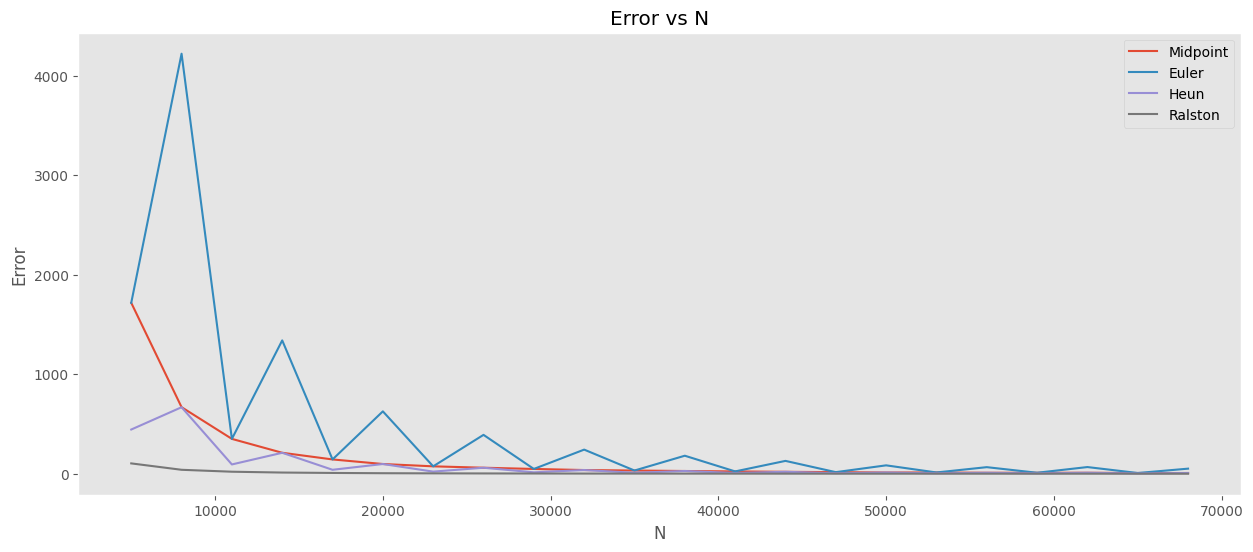

In [16]:
# we see focus on asymptotic error
N_values = np.arange(5000, 70000, 3000)


#These will contain the errors correspondiing to certain N values
error_midpoint = np.zeros(len(N_values))
error_Euler = np.zeros(len(N_values))
error_Heun = np.zeros(len(N_values))
error_Ralston = np.zeros(len(N_values))

for i in range(len(N_values)):
    Ralston = rk_order2(x0, derivative, t0, tN, N_values[i],2/3)
    euler = Euler(x0, t0, tN, derivative, N_values[i])
    Heun = rk_order2(x0, derivative, t0, tN, N_values[i],1/2)
    Midpoint = rk_order2(x0, derivative, t0, tN, N_values[i],1)

    # compute the error between the whole matrices yi and y
    error_midpoint[i] = Matrices_comparison(Midpoint, y)
    error_Euler[i] = Matrices_comparison(euler, y)
    error_Heun[i] = Matrices_comparison(Heun, y)
    error_Ralston[i] = Matrices_comparison(Ralston, y)
    
# Plotting all errors in the same graph
plt.figure(figsize=(15, 6))

plt.plot(N_values, error_midpoint, label="Midpoint")
plt.plot(N_values, error_Euler, label="Euler")
plt.plot(N_values, error_Heun, label="Heun")
plt.plot(N_values, error_Ralston, label="Ralston")

plt.xlabel("N")
plt.ylabel("Error")
plt.title("Error vs N")
plt.legend()
plt.grid()
plt.show()

We see that for very large values of N , the error continues to converge towards 0, so we can conjecture that this behavior will persist for values of N even larger (but going above the limits of number representation on our machine)

## Consistance

To verify the consistance of our methods, we use the theorem seen in ths course and we calculate the sum of erros and then we plot the results, As we can see that the sum of the norms of the erros converges to zero :  
$$\lim_{h \to 0} \sum_{n=0}^{N-1} \lVert e_n \rVert = 0 $$

So we can say that those  methods are consistant

We can also use a theorical approach to prove tne consistance : 
 The one-step method defined by $\phi $ is consistent if and only if: 
 
 for all $ t$ in $ [t_0, t_0 + T] $ and for all $ y $ in $\mathbb{R}^m $, $ \phi(t, y, 0) = f(t, y) $ which we can simply verify


In [17]:
def error_one_value(true_val,approx_val,i):

  error = 0

  sizeRatio = true_val.shape[0] // approx_val.shape[0]

  for j in range(approx_val.shape[1]):

    error += ((true_val[i*sizeRatio, j] - approx_val[i, j]))**2

  return error

def error_sum(N):
  yiRK4 = rk4(x0, derivative, t0, tN, N)
  yiEuler = Euler(x0, t0, tN, derivative, N)
  yiMid = rk_order2(x0, derivative, t0, tN, N,1)
  yiRalston = rk_order2(x0, derivative, t0, tN, N,2/3)
  error_sum_RK4 = 0
  error_sum_Euler = 0
  error_sum_Mid = 0
  error_sum_Ralston = 0
  for i in range(N):
    error_sum_RK4 += error_one_value(y,yiRK4,i)
    error_sum_Euler +=error_one_value(y,yiEuler,i)
    error_sum_Mid +=error_one_value(y,yiMid,i)
    error_sum_Ralston +=error_one_value(y,yiRalston,i)

  

  return error_sum_RK4,error_sum_Euler,error_sum_Ralston,error_sum_Mid

list_N = np.arange(100, 20000, 100)

error_RK4_N = {}
error_Euler_N = {}
error_Ralston_N = {}
error_Mid_N = {}

for N in list_N:
    errors = error_sum(N)
    error_RK4_N[N] = errors[0]
    error_Euler_N[N] = errors[1]
    error_Ralston_N[N] = errors[2]
    error_Mid_N[N] = errors[3]





C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:40: RuntimeWarning: overflow encountered in scalar multiply
  return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: overflow encountered in scalar multiply
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:52: RuntimeWarning: invalid value encountered in scalar divide
  return 280*KCO2*(HCO3**2/CO3)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:48: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
C:\Users\marye\AppData\Local\Temp\ipykernel_63892\2907972119.py:36: RuntimeWarning: invalid value encountered in scalar divide
  return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
C:\Users\marye\AppData\Local\Temp\ipyke

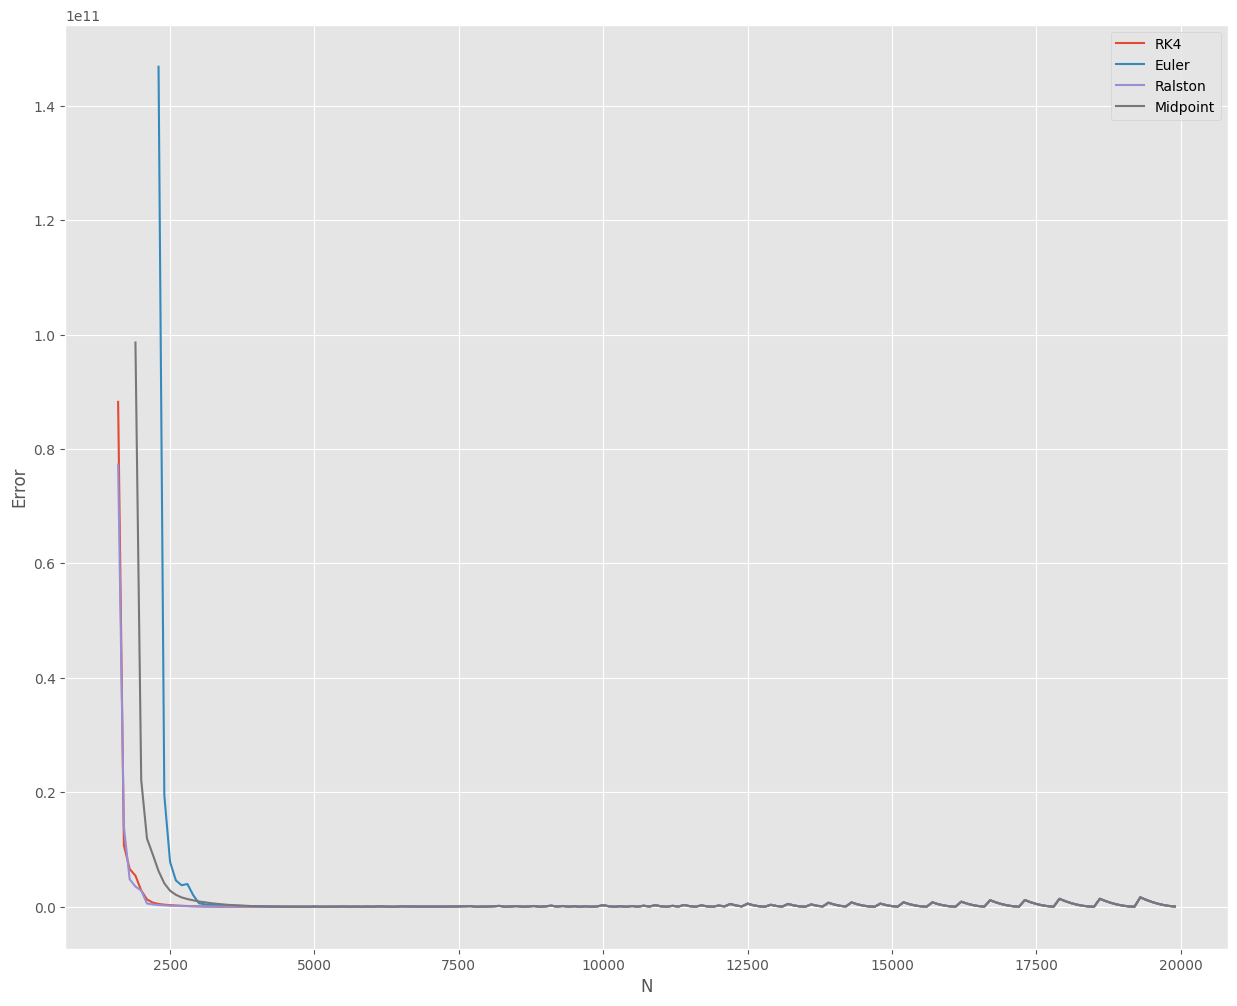

In [18]:
plt.figure(figsize=(15, 12))

# Plot errors for RK4
plt.plot(list_N, [error_RK4_N[N] for N in list_N], label="RK4")

# Plot errors for Heun


# Plot errors for Euler
plt.plot(list_N, [error_Euler_N[N] for N in list_N], label="Euler")

# Plot errors for Ralston
plt.plot(list_N, [error_Ralston_N[N] for N in list_N], label="Ralston")

# Plot errors for Midpoint
plt.plot(list_N, [error_Mid_N[N] for N in list_N], label="Midpoint")

plt.xlabel("N")
plt.ylabel("Error")
plt.legend()
plt.show() 

 **Conclusion** 
 
We have proven theoretically and numerically that the methods used are consistent, as the sum of the errors converges to 0 when N tends to infinity

## Stability


Here we will use a theorical approach using a theorem seen in the course :  

If f is Lipschity with constant k, then the Runge Kutta method $\phi$ is stable with constant $S = s^{\Lambda T}$, where:
$$ \Lambda = k \sum_{i = 1}^{p} |b_j| (1 + (\alpha k h_{max}) + ... + (\alpha k h_{max})^{j - 1}) $$


We want to see if $f(t,y)$ is Lipschitz with respect to y. So we can plot $$ \frac{\| f(t,y1) - f(t,y2) \|}{\|y1 - y2 \|} $$

But then this will also depend on the norm that we will take, however, in $\mathbb{R}^m$ all norms are equivalent, so if we find that it is Lipschitz with respect to some norm, then it is Lipschitz for all other norms.

For simplicity, we choose the $\|.\|_{\infty}$

The function that we will plot is the following:

$$ \psi(h) = \frac{\| f(t,y1) - f(t,y1 + h) \|}{\|h \|} $$

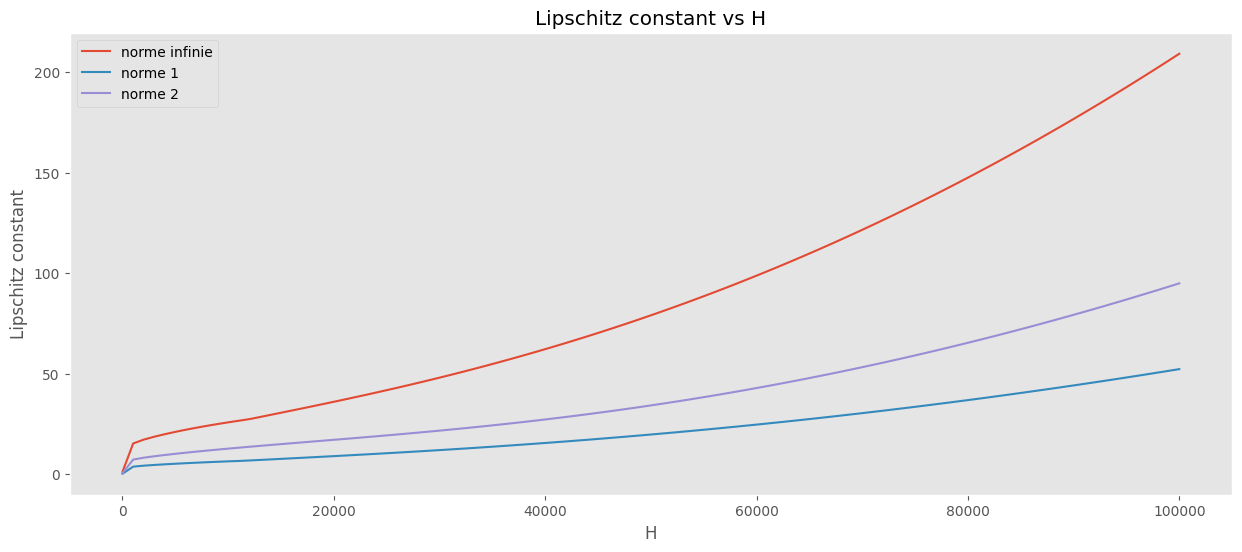

In [24]:
def isLipschitz(f, t, x0):

    H = np.linspace(1, 100000, 100)
    y1 = x0
    valuesinf = []
    values1 = []
    values2 = []
    for h in H:
        y2 = y1 + h * np.ones(8)
        num = np.linalg.norm(f(y1, t) - f(y2, t), np.inf)
        den = np.linalg.norm(y1 - y2, np.inf)
        den1 = np.linalg.norm(y1 - y2, 1)
        den2 = np.linalg.norm(y1 - y2, 2)
        num1 = np.linalg.norm(f(y1, t) - f(y2, t), 1)
        num2 = np.linalg.norm(f(y1, t) - f(y2, t), 2)
        valuesinf.append(num / den)
        values1.append(num1 / den1)
        values2.append(num2 / den2)

    plt.figure(figsize = (15, 6))
    plt.plot(H, valuesinf, label = "norme infinie")
    plt.plot(H, values1, label = "norme 1")
    plt.plot(H, values2, label = "norme 2")
    plt.xlabel("H")
    plt.ylabel("Lipschitz constant")
    plt.title("Lipschitz constant vs H")
    plt.legend()
    plt.grid()
    plt.show()

t = 1
isLipschitz(derivative, t, x0)

It is **not** Lipschitz , since we $\psi(h)$ is not bounded for all $h $ in $\mathbb{R}^8$. so we can not conculde about the stability of the methods

## Convergence

Using a theorem from the course that states stability and consistency imply convergence, we have established that all the methods used are consistent. However, we cannot conclude about the stability since f is not Lipschitz, so we cannot infer convergence either.